In [4]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from config import *
from ssqa import *
from ss_inference import *
from data import *
from pgm import *
from generation import *

DATA = PFAM_DATA
DATASET = "russ"
warnings.filterwarnings("ignore")

## SS3 prediction

In [5]:
model_ss = NetSurfP2(50, "netsurfp2")
optimizer = optim.Adam(model_ss.parameters(), lr=0.001)
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))
model_ss.eval()
model_ss = model_ss.to("cuda")

model_ss

Model netsurfp2-50

## Data

In [6]:
dataset = SSQAData_RBM(f"{DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset, batch_size = 100, shuffle = True)
batch_size, q, N = dataset.seqs.size()

Available :  seq L cluster_index weights subset seq_hmm pattern ss_hmm


In [7]:
from torch.distributions.one_hot_categorical import OneHotCategorical

independant = torch.zeros(q+1, N)
for w, v in zip(dataset.weights,dataset):
    independant += w*v
independant /= dataset.weights.sum()
independant = independant.float().to(device).t()

independant_sampler = OneHotCategorical(independant)

In [8]:
pots = torch.zeros(q+1, N)
for w, v in zip(dataset.weights,dataset):
    pots += w*v
pots /= torch.sum(dataset.weights)
pots = (pots-pots.mean(0)[None]).view(-1).float().to(device)

## RBM

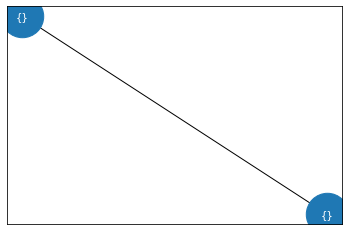

Iteration 0 : -0.0016033172141760588
Iteration 200 : 1.6510608664211759
Iteration 400 : 6.8313688228336105
Iteration 600 : 16.189521780466748
Iteration 800 : 31.201827040171338
Iteration 1000 : 55.03970955148907
Iteration 1200 : 93.3154599650261
Iteration 1400 : 153.46499866083832
Iteration 1600 : 238.7796065791008
Iteration 1800 : 346.88971111015053
Estimated Z : 9.912


9.912199974060059

In [9]:
visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=q+1, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

model1 = MRF(layers = {v.name: v,
                    h.name: h},
            edges = E,
            name = "")

for visible in visible_layers:
    edge = model1.get_edge(visible, "hidden")
    
model1.load(f"{DATA}/{DATASET}/weights/seq-reg-200_4320.h5")
model1.ais(n_inter = 2000, verbose = True)

## Rejection Sampling

In [107]:
class IndependantSampler(Sampler):
    def __init__(self, p):
        super(IndependantSampler, self).__init__()
        self.sampler = OneHotCategorical(p)
        self.p = p

    def sample(self, data):
        n = data.size(0)
        return self.sampler.sample_n(n).permute(0, 2, 1)

class NaturalSampler(Sampler):
    def __init__(self):
        super(NaturalSampler, self).__init__()

    def sample(self, data):
        return data.permute(0, 2, 1)

class PGMSampler(Sampler):
    def __init__(self, model, visible_layers, hidden_layers, k = 30):
        super(PGMSampler, self).__init__()
        self.model = model
        self.visible_layers = visible_layers
        self.hidden_layers = hidden_layers
        self.k = k

    def sample(self, data):
        d_0 = {k: v.float().to(device) for k, v in zip(LAYERS_NAME, [data]) if
               k in self.visible_layers}
        _, d_f = self.model.gibbs_sampling(d_0, self.visible_layers, self.hidden_layers, k=self.k)
        return d_f["sequence"]

class RejectionSampler(object):
    def __init__(self, loader, ssqa):
        super(RejectionSampler, self).__init__()
        self.ssqa = ssqa
        self.loader = loader

    def sample(self, sampler, n_samples, thr):
        samples = []
        while True:
            for batch_idx, data in enumerate(self.loader):
                print(f"{len(samples)}/{n_samples} [{int(100 * len(samples) / n_samples)}%]", end="\r")
                x = sampler.sample(data)
                dp, pm = self.ssqa.featuring(X, None)
                _, pm_unsup, _, _ = self.ssqa.predict(dp, pm)
                for x_, pm_ in zip(x, pm_unsup):
                    if len(samples) >= n_samples:
                        return samples
                    if pm_ > thr:
                        samples.append((x_, pm_))

In [108]:
ssqa = SSQA(model_ss)
ssqa.load(f"{DATA}/{DATASET}/ssqa.pt")

ind_sampler = IndependantSampler(independant)
nat_sampler = NaturalSampler()
pgm_sampler = PGMSampler(model1, ["sequence"], ["hidden"])

rejection_sampler = RejectionSampler(loader, ssqa)

In [109]:
all_samples_hist = []
all_samples = []
Ts = [0.5, 0.6, 0.65, 0.7]
for T in Ts:
    start = time.time()
    samples = rejection_sampler.sample(pgm_sampler, 500, T)
    all_samples_hist.append([x[1] for x in samples])
    all_samples.append([x[0] for x in samples])
    print(f"T = {T} || Samples/seconds : {int(500/(time.time()-start))}")

T = 0.5 || Samples/seconds : 34
T = 0.6 || Samples/seconds : 32
T = 0.65 || Samples/seconds : 9
T = 0.7 || Samples/seconds : 0


In [110]:
all_samples = [torch.cat([s_.view(1, *s_.size()) for s_ in s],0) for s in all_samples]
for T, s in zip(Ts, all_samples):
    torch.save(s, f"{DATA}/{DATASET}/gen_data/rbm_local_rejection_sampling_T_{T}.pt")

In [111]:
all_samples_hist = []
all_samples = []
Ts = [0.5, 0.6, 0.65, 0.7]
for T in Ts:
    start = time.time()
    samples = rejection_sampler.sample(ind_sampler, 500, T)
    all_samples_hist.append([x[1] for x in samples])
    all_samples.append([x[0] for x in samples])
    print(f"T = {T} || Samples/seconds : {int(500/(time.time()-start))}")

T = 0.5 || Samples/seconds : 36
T = 0.6 || Samples/seconds : 31
T = 0.65 || Samples/seconds : 9
T = 0.7 || Samples/seconds : 0


In [112]:
all_samples = [torch.cat([s_.view(1, *s_.size()) for s_ in s],0) for s in all_samples]
for T, s in zip(Ts, all_samples):
    torch.save(s, f"{DATA}/{DATASET}/gen_data/ind_local_rejection_sampling_T_{T}.pt")